In [1]:
import numpy as np; 
import matplotlib.pyplot as plt; 

In [2]:
def get_metaDict(metaname):
    metaDict = {}
    with open(metaname) as f:
        mdatList = f.read().splitlines()
        # convert the list entries into key value pairs
        for m in mdatList:
            csList = m.split(sep='=')
            if csList[0][0] == '~':
                currKey = csList[0][1:len(csList[0])]
            else:
                currKey = csList[0]
            metaDict.update({currKey: csList[1]})
    return metaDict;


def get_sync_dur(rawdata, sample_rate):
    if np.shape(rawdata)[1]==385:
        syncON = np.where(rawdata[:sample_rate*10, 384]==64)[0][0]; 
        syncOFF = np.where(rawdata[-sample_rate*10:, 384]==64)[0][0] + np.shape(rawdata)[0] - sample_rate*20;     
    else:
        syncON = np.where(rawdata[:sample_rate*10, 0]>10000)[0][0]; 
        syncOFF = np.where(rawdata[-sample_rate*10:, 0]>10000)[0][0] + np.shape(rawdata)[0] - sample_rate*20;     

    sync_dur = (syncOFF - syncON) / sample_rate; 
    return sync_dur; 

In [11]:
filedir = '/Volumes/share/Anesthetized_Experiments/rawData/V4/2024_04/P1/10_TextureFlow_LE_P1_gt_t1_g0/'; 

nidq_name = filedir + 'TextureFlow_LE_P1_gt_t1_g0_t0.nidq.bin'; 
ap_name = filedir + 'TextureFlow_LE_P1_gt_t1_g0_imec0/TextureFlow_LE_P1_gt_t1_g0_t0.imec0.ap.bin'; 
lf_name = filedir + 'TextureFlow_LE_P1_gt_t1_g0_imec0/TextureFlow_LE_P1_gt_t1_g0_t0.imec0.lf.bin'; 

In [6]:
nidq_meta = get_metaDict(nidq_name[:-3]+'meta'); 
nidq_syncCH = int(nidq_meta['syncNiChan'])
nidq_nChan = int(nidq_meta['nSavedChans']); 
nidq_nFileSamp = int(int(nidq_meta['fileSizeBytes'])/(2*nidq_nChan)); 
nidq_SampRate = int(nidq_meta['niSampRate']); 

ap_meta = get_metaDict(ap_name[:-3]+'meta'); 
ap_nChan = int(ap_meta['nSavedChans']); 
ap_nFileSamp = int(int(ap_meta['fileSizeBytes'])/(2*ap_nChan)); 
ap_imSampRate = int(ap_meta['imSampRate']); 

lf_meta = get_metaDict(lf_name[:-3]+'meta'); 
lf_nChan = int(lf_meta['nSavedChans']); 
lf_nFileSamp = int(int(lf_meta['fileSizeBytes'])/(2*lf_nChan)); 
lf_imSampRate = int(lf_meta['imSampRate']);        

In [7]:
nidq_data = np.memmap(nidq_name, dtype='int16', 
                      shape=(nidq_nFileSamp, nidq_nChan), offset=0, order='C'); 
nidq_sync = nidq_data[:,0].copy(); 
nidq_sHigh = np.where(nidq_sync>10000)[0]; 
nidq_sOFF = np.concatenate((nidq_sHigh[np.where(np.diff(nidq_sHigh)>10)[0]], [nidq_sHigh[-1]])); 
nidq_sON = np.concatenate(([nidq_sHigh[0]], nidq_sHigh[np.where(np.diff(nidq_sHigh)>10)[0]+1])); 

print(len(nidq_sON),len(nidq_sOFF))
print(np.min(nidq_sOFF-nidq_sON),np.max(nidq_sOFF-nidq_sON))

85000 85000
124 125


In [8]:
lf_data = np.memmap(lf_name, dtype='int16', 
                    shape=(lf_nFileSamp, lf_nChan), offset=0, mode='r',order='C'); 
lf_sync = lf_data[:,384].copy(); 
del lf_data; 

lf_sHigh = np.where(lf_sync==64)[0]; 
lf_sON = np.concatenate(([lf_sHigh[0]], lf_sHigh[np.where(np.diff(lf_sHigh)>10)[0]+1])); 
lf_sOFF = np.concatenate((lf_sHigh[np.where(np.diff(lf_sHigh)>10)[0]], [lf_sHigh[-1]])); 

if lf_sON[0]==0:
    lf_sON = lf_sON[1:]; 
    lf_sOFF = lf_sOFF[1:]; 

print(len(lf_sON),len(lf_sOFF))
print(np.min(lf_sOFF - lf_sON), np.max(lf_sOFF - lf_sON))

85000 85000
0 12


In [12]:
sON_valid_idx0 = len(nidq_sON) - len(lf_sON); 
nidq_sync_dur = (nidq_sOFF[-1]-nidq_sON[sON_valid_idx0])/nidq_SampRate; 

ap_data = np.memmap(ap_name, dtype='int16', 
                    shape=(ap_nFileSamp, ap_nChan), offset=0, order='C'); 

ap_sHigh_start = np.where(ap_data[:int(ap_imSampRate*10),384]==64)[0]; 
ap_sONs = np.concatenate(([ap_sHigh_start[0]], ap_sHigh_start[np.where(np.diff(ap_sHigh_start)>10)[0]+1])); 
if ap_sONs[0]==0:
    ap_sON = ap_sONs[1]; 
else:
    ap_sON = ap_sONs[0]; 


In [ ]:
lf_sOff[-1]

In [13]:
ap_sHigh_end = np.where(ap_data[-int(ap_imSampRate*10):,384]==64)[0]; 

In [22]:
(lf_nFileSamp-lf_sOFF[-1])/lf_imSampRate

106.8756

In [9]:
ap_data = np.memmap(ap_name, dtype='int16', 
                    shape=(ap_nFileSamp, ap_nChan), offset=0, mode='r',order='C'); 
ap_sync = ap_data[:,384].copy(); 
del ap_data; 

ap_sHigh = np.where(ap_sync==64)[0]; 
ap_sON = np.concatenate(([ap_sHigh[0]], ap_sHigh[np.where(np.diff(ap_sHigh)>10)[0]+1])); 
ap_sOFF = np.concatenate((ap_sHigh[np.where(np.diff(ap_sHigh)>10)[0]], [ap_sHigh[-1]])); 

if ap_sON[0]==0:
    ap_sON = ap_sON[1:]; 
    ap_sOFF = ap_sOFF[1:]; 

print(len(ap_sON),len(ap_sOFF))
print(np.min(ap_sOFF - ap_sON), np.max(ap_sOFF - ap_sON))

6799 6799
1469 6000


In [17]:
lf_sON

array([    475,    1100,    1725, ..., 4247638, 4248263, 4248888])

In [30]:
ap_data = np.memmap(ap_name, dtype='int16', 
                    shape=(ap_nFileSamp, ap_nChan), offset=0, mode='r',order='C'); 
ap_sHigh = np.where(ap_data[:int(ap_imSampRate*10),384]==64)[0]; 
ap_sON = np.concatenate(([ap_sHigh[0]], ap_sHigh[np.where(np.diff(ap_sHigh)>10)[0]+1])); 


In [33]:
ap_sON

array([     0,   5697,  13197,  20697,  28197,  35697,  43197,  50697,
        58188,  65688,  73188,  80688,  88188,  95689, 103189, 110689,
       118189, 125689, 133189, 140689, 148189, 155689, 163189, 170689,
       178189, 185690, 193190, 200690, 208190, 215690, 223190, 230690,
       238190, 245681, 253181, 260681, 268181, 275681, 283181, 290681,
       298181])

In [35]:
ap_sHigh_end = np.where(ap_data[-int(ap_imSampRate*10):,384]==64)[0]; 

In [36]:
ap_sOFF = ap_sHigh_end[-1] + ap_nFileSamp - ap_imSampRate*10;    


In [37]:
ap_sON

array([     0,   5697,  13197,  20697,  28197,  35697,  43197,  50697,
        58188,  65688,  73188,  80688,  88188,  95689, 103189, 110689,
       118189, 125689, 133189, 140689, 148189, 155689, 163189, 170689,
       178189, 185690, 193190, 200690, 208190, 215690, 223190, 230690,
       238190, 245681, 253181, 260681, 268181, 275681, 283181, 290681,
       298181])

In [40]:
sON_valid_idx0 = len(nidq_sON) - len(lf_sON); 
nidq_sync_dur = (nidq_sOFF[-1]-nidq_sON[sON_valid_idx0])/nidq_SampRate; 

In [42]:
(ap_sOFF - ap_sON[1])/nidq_sync_dur

29997.203191935892

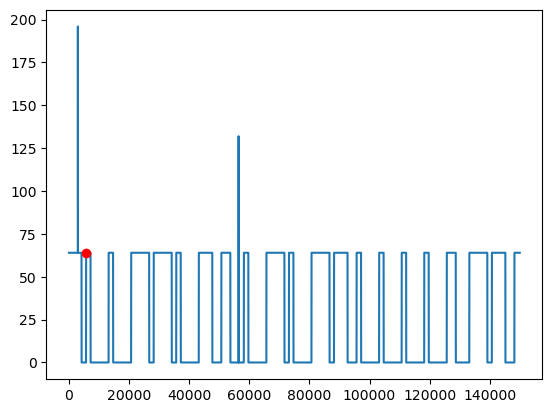

In [34]:
plt.plot(ap_data[:int(ap_imSampRate)*5,384])
plt.plot(5697,64,'ro')

In [192]:
print((nidq_sOFF[-1]-nidq_sON[0])/25000)
print((lf_sOFF[-1]-lf_sON[0])/2500)
print((ap_sOFF[-1]-ap_sON[0])/30000)

1947.12676
1946.9992
1946.9996


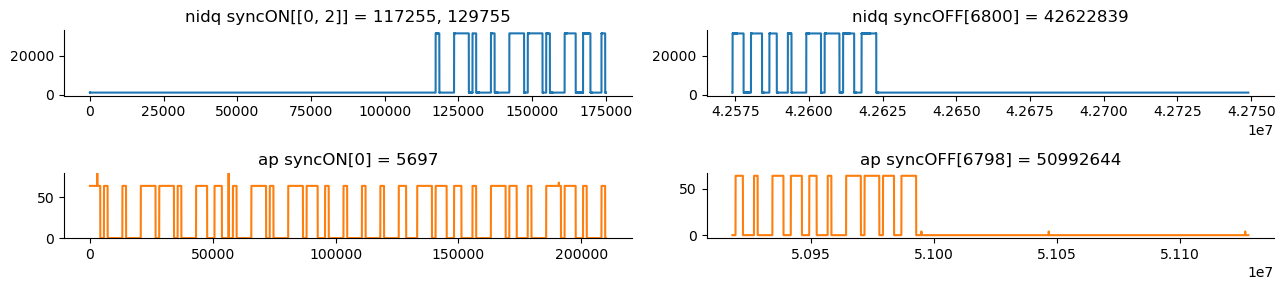

In [102]:
### ABNORMAL
ap_data = np.memmap(ap_name, dtype='int16', 
                    shape=(ap_nFileSamp, ap_nChan), offset=0, mode='r',order='C'); 

nidq_x1 = np.arange(0,int(nidq_SampRate*7)); 
nidq_x2 = np.arange(
    len(nidq_sync)-int(nidq_SampRate*7),
    len(nidq_sync)
)
ap_x1 = np.arange(0,int(ap_imSampRate*7)); 
ap_x2 = np.arange(
    np.shape(ap_data)[0]-int(ap_imSampRate*7),
    np.shape(ap_data)[0]
)

plt.figure(figsize=(13,3))
plt.subplot(2,2,1); 
plt.plot(nidq_x1,nidq_sync[nidq_x1[0]:nidq_x1[-1]+1],'C0')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title(f'nidq syncON[[0, {len(nidq_sOFF)-len(ap_sOFF)}]] = {nidq_sON[0]}, {nidq_sON[len(nidq_sOFF)-len(ap_sOFF)]}')
plt.subplot(2,2,2); 
plt.plot(nidq_x2,nidq_sync[nidq_x2[0]:nidq_x2[-1]+1],'C0')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title(f'nidq syncOFF[{len(nidq_sOFF)-1}] = {nidq_sOFF[-1]}')
plt.subplot(2,2,3); 
plt.plot(ap_x1,ap_data[ap_x1[0]:ap_x1[-1]+1,384],'C1')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title(f'ap syncON[0] = {ap_sON[0]}')
plt.ylim([0,80]); 
plt.subplot(2,2,4); 
plt.plot(ap_x2,ap_data[ap_x2[0]:ap_x2[-1]+1,384],'C1')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title(f'ap syncOFF[{len(ap_sOFF)-1}] = {ap_sOFF[-1]}')

plt.tight_layout()

In [106]:
(50992644-5697)/29997.2032

1699.7233595430657

Text(0, 0.5, 'Time difference between nidq and ap (ms)')

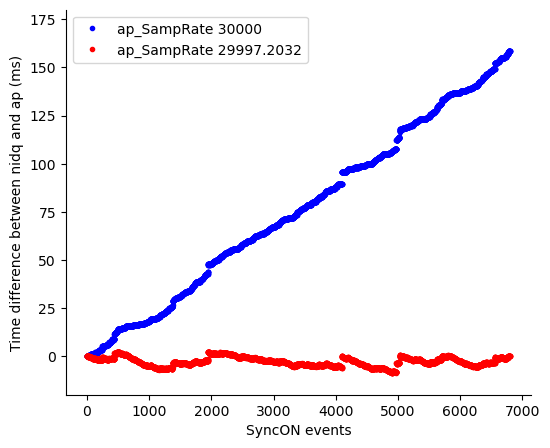

In [134]:
plt.figure(figsize=(6,5))
plt.plot(1000*(nidq_sON[2:] - nidq_sON[2])/25000 - 1000*(ap_sON - ap_sON[0])/30000,'b.',label='ap_SampRate 30000')
plt.plot(1000*(nidq_sON[2:] - nidq_sON[2])/25000 - 1000*(ap_sON - ap_sON[0])/29997.2032,'r.',label='ap_SampRate 29997.2032')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.ylim([-20,180])
plt.legend()
plt.xlabel('SyncON events')
plt.ylabel('Time difference between nidq and ap (ms)')


In [144]:
aaa = 1000*(nidq_sON[2:] - nidq_sON[2])/25000 - 1000*(ap_sON - ap_sON[0])/30000
np.where(np.diff(aaa)>2)[0]

array([ 439, 1375, 1945, 4097, 4974, 5024, 6556])

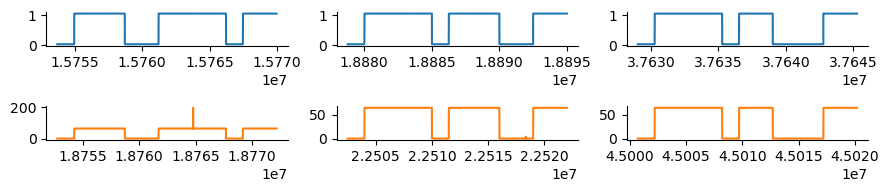

In [140]:
good_sync = [2500,3000,6000]; 
plt.figure(figsize=(9,2))
for i, t in enumerate(good_sync):
    nidq_x = [nidq_sON[t+2]-int(0.05*nidq_SampRate),
              nidq_sON[t+2]+int(0.6*nidq_SampRate)];  
    ap_x = [ap_sON[t]-int(0.05*29997.2032),
            ap_sON[t]+int(0.6*29997.2032)];  
    plt.subplot(2,3,i+1); 
    plt.plot(np.arange(nidq_x[0],nidq_x[1]), nidq_sync[nidq_x[0]:nidq_x[1]]/30000,'C0'); 
    plt.gca().spines[['right', 'top']].set_visible(False)

    plt.subplot(2,3,i+4); 
    plt.plot(np.arange(ap_x[0],ap_x[1]), ap_sync[ap_x[0]:ap_x[1]],'C1'); 
    plt.gca().spines[['right', 'top']].set_visible(False)   
plt.tight_layout()

In [158]:
bad_sync

array([ 841, 5199, 9556])

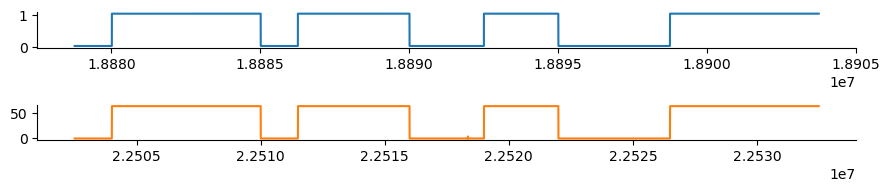

In [150]:
#bad_sync = np.where(np.diff(ap_sON)<700)[0][[0,1,3]]; 
bad_sync = [3000]
plt.figure(figsize=(9,2))
for i, t in enumerate(bad_sync):
    nidq_x = [nidq_sON[t+2]-int(0.05*nidq_SampRate),
              nidq_sON[t+2]+int(0.95*nidq_SampRate)];  
    ap_x = [ap_sON[t]-int(0.05*29997.2032),
            ap_sON[t]+int(0.95*29997.2032)];  
    plt.subplot(2,1,i+1); 
    plt.plot(np.arange(nidq_x[0],nidq_x[1]), nidq_sync[nidq_x[0]:nidq_x[1]]/30000,'C0'); 
    plt.gca().spines[['right', 'top']].set_visible(False)

    plt.subplot(2,1,i+2); 
    plt.plot(np.arange(ap_x[0],ap_x[1]), ap_sync[ap_x[0]:ap_x[1]],'C1'); 
    plt.gca().spines[['right', 'top']].set_visible(False)   
plt.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (45000,) and (0,)

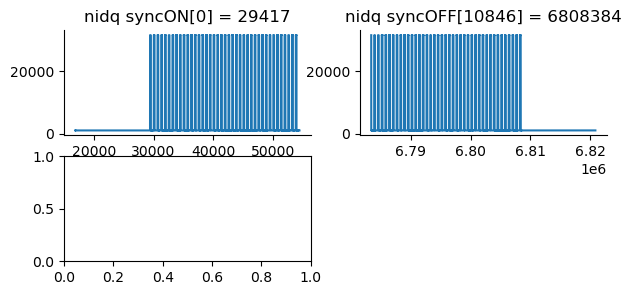

In [159]:
### NORMAL

nidq_x1 = np.arange(
    nidq_sON[0]-int(nidq_SampRate*0.5),
    nidq_sON[0]+int(nidq_SampRate*1),
)
nidq_x2 = np.arange(
    nidq_sOFF[-1]-int(nidq_SampRate*1),
    nidq_sOFF[-1]+int(nidq_SampRate*0.5),
)
ap_x1 = np.arange(
    ap_sON[0]-int(ap_imSampRate*0.5),
    ap_sON[0]+int(ap_imSampRate*1),
)
ap_x2 = np.arange(
    ap_sOFF[-1]-int(ap_imSampRate*1),
    ap_sOFF[-1]+int(ap_imSampRate*0.5),
)

plt.figure(figsize=(7,3))
plt.subplot(2,2,1); 
plt.plot(nidq_x1,nidq_sync[nidq_x1[0]:nidq_x1[-1]+1],'C0')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title(f'nidq syncON[0] = {nidq_sON[0]}')
plt.subplot(2,2,2); 
plt.plot(nidq_x2,nidq_sync[nidq_x2[0]:nidq_x2[-1]+1],'C0')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title(f'nidq syncOFF[{len(nidq_sOFF)-1}] = {nidq_sOFF[-1]}')
plt.subplot(2,2,3); 
plt.plot(ap_x1,ap_data[ap_x1[0]:ap_x1[-1]+1,384],'C1')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title(f'ap syncON[0] = {ap_sON[0]}')
plt.subplot(2,2,4); 
plt.plot(ap_x2,ap_data[ap_x2[0]:ap_x2[-1]+1,384],'C1')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.title(f'ap syncOFF[{len(ap_sOFF)-1}] = {ap_sOFF[-1]}')

plt.tight_layout()

Text(0, 0.5, 'Time difference between nidq and ap (ms)')

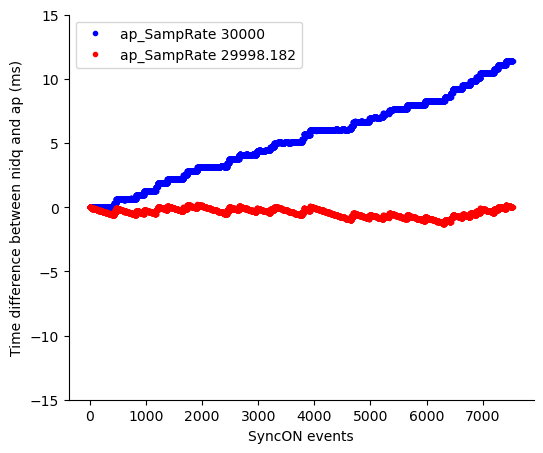

In [85]:
plt.figure(figsize=(6,5))
plt.plot(1000*(nidq_sON - nidq_sON[0])/25000 - 1000*(ap_sON - ap_sON[0])/30000,'b.',label='ap_SampRate 30000')
plt.plot(1000*(nidq_sON - nidq_sON[0])/25000 - 1000*(ap_sON - ap_sON[0])/29998.182230007504,'r.',label='ap_SampRate 29998.182')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.ylim([-15,15])
plt.legend()
plt.xlabel('SyncON events')
plt.ylabel('Time difference between nidq and ap (ms)')


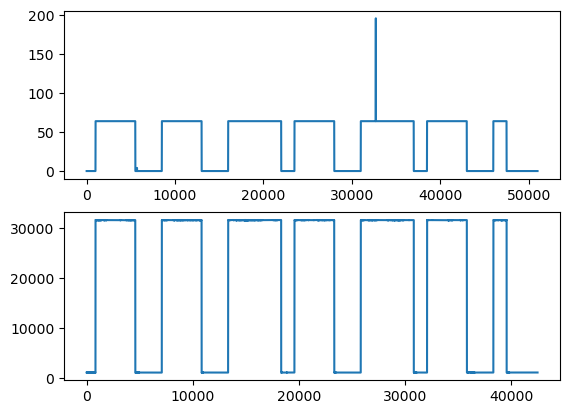

In [267]:
plt.subplot(2,1,1)
plt.plot(ap_sync[ap_sON[-300]-1000:ap_sON[-300]+50000])
plt.subplot(2,1,2)
plt.plot(nidq_sync[nidq_sON[-300]-int(1000*25/30):nidq_sON[-300]+int(50000*25/30)])

In [243]:
np.where(np.diff(ap_sON)==np.min(np.diff(ap_sON)))

(array([10070]),)

In [254]:
(ap_sON[-1]-ap_sON[-3710])/ap_imSampRate

927.1686333333333

In [255]:
(nidq_sON[-1]-nidq_sON[-3710])/nidq_SampRate

927.26276

In [256]:
(ap_sON[-1]-ap_sON[-3710]) / ((nidq_sON[-1]-nidq_sON[-3710])/nidq_SampRate)

29996.95469275613

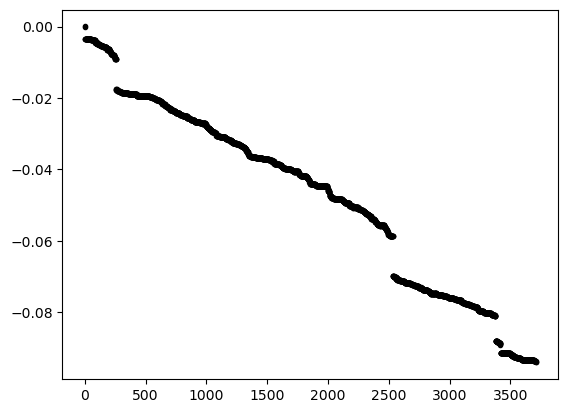

In [257]:
plt.plot((ap_sON[-3710:] - ap_sON[-3710])/ap_imSampRate - (nidq_sON[-3710:]-nidq_sON[-3710])/nidq_SampRate, 'k.')

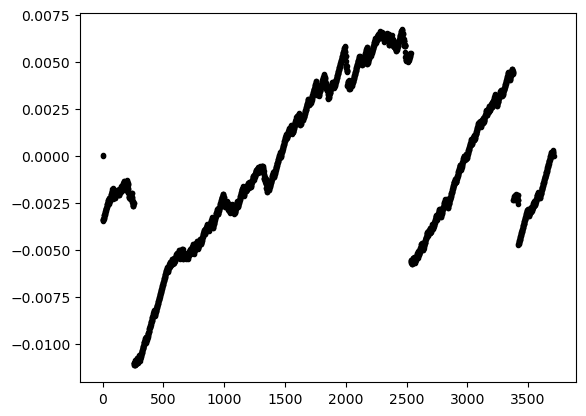

In [259]:
plt.plot((ap_sON[-3710:] - ap_sON[-3710])/29996.95469275613 - (nidq_sON[-3710:]-nidq_sON[-3710])/nidq_SampRate, 'k.')

In [19]:
from tqdm import tqdm

ap_data = np.memmap(ap_name, dtype='int16', 
                    shape=(ap_nFileSamp, ap_nChan), offset=0, mode='r',order='C'); 
nChunks = int(np.ceil(np.shape(ap_data)[0]/(ap_imSampRate*10))); 

ap_sOFF = []; 
ap_sON = []; 
for i in tqdm(np.arange(nChunks)):

    if i != nChunks-1:
        ap_sync = ap_data[i*10*ap_imSampRate:(i+1)*10*ap_imSampRate,384].copy(); 
    else:
        ap_sync = ap_data[i*10*ap_imSampRate:,384].copy(); 

    sHigh = np.where(ap_sync==64)[0]; 
    if (len(sHigh)>0) and (sHigh[0]>0):
        ap_sON_now = np.concatenate(([sHigh[0]], sHigh[np.where(np.diff(sHigh)>10)[0]+1])); 
    else:
        ap_sON_now = sHigh[np.where(np.diff(sHigh)>10)[0]+1]; 

    if (len(sHigh)>0) and (sHigh[-1]<(len(ap_sync)-1)): 
        ap_sOFF_now = np.concatenate((sHigh[np.where(np.diff(sHigh)>10)[0]], [sHigh[-1]])); 
    else:
        ap_sOFF_now = sHigh[np.where(np.diff(sHigh)>10)[0]]; 

    if len(ap_sOFF_now)>0:
        ap_sOFF_now += i*10*lf_imSampRate; 

    if len(ap_sON_now)>0:
        ap_sON_now += i*10*lf_imSampRate; 


    #if len(ap_sON_pre)>0:
    #    ap_ON_now = ap_sON_pre[np.where(ap_sync[ap_sON_pre+1]==64)[0]] + i*10*lf_imSampRate; 
    #if len(ap_sOFF_pre)>0:
    #    ap_sON_now += i*10*lf_imSampRate; 

    ap_sOFF.extend(ap_sOFF_now); 
    ap_sON.extend(ap_sON_now); 

100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


In [73]:
lf_data = np.memmap(lf_name, dtype='int16', 
                    shape=(lf_nFileSamp, lf_nChan), offset=0, mode='r',order='C'); 
lf_sync = lf_data[:,384].copy()
lf_sync[np.where(lf_sync>64)[0]] = 64; 
lf_sync[np.where(lf_sync<64)[0]] = 0; 

In [75]:
sHigh = np.where(lf_sync==64)[0]; 
lf_sON = np.concatenate(([sHigh[0]], sHigh[np.where(np.diff(sHigh)>10)[0]+1])); 
lf_sOFF = np.concatenate((sHigh[np.where(np.diff(sHigh)>10)[0]], [sHigh[-1]])); 


In [76]:
len(np.where((lf_sync[lf_sOFF+1]==0) & (lf_sync[lf_sOFF-1]==64))[0])

75983

In [77]:
len(np.where((lf_sync[lf_sON+1]==64) & (lf_sync[lf_sON-1]==0))[0])

75975

(array([4.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7000e+01,
        7.5944e+04, 5.0000e+00, 4.0000e+00, 0.0000e+00, 7.0000e+00]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <BarContainer object of 10 artists>)

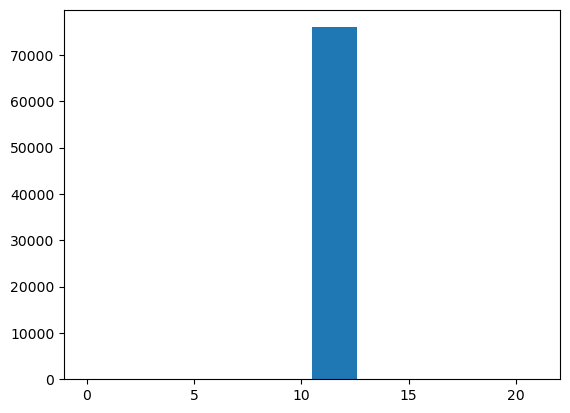

In [83]:
plt.hist(lf_sOFF-lf_sON)

In [79]:
len(lf_sOFF)

76027

In [62]:
from tqdm import tqdm

lf_data = np.memmap(lf_name, dtype='int16', 
                    shape=(lf_nFileSamp, lf_nChan), offset=0, mode='r',order='C'); 
nChunk = int(np.ceil(np.shape(lf_data)[0]/(lf_imSampRate*10))); 

lf_sOFF = []; 
lf_sON = []; 
for i in tqdm(np.arange(nChunk)):

    if i != nChunk-1:
        lf_sync = lf_data[i*10*lf_imSampRate:(i+1)*10*lf_imSampRate,384]; 
    else:
        lf_sync = lf_data[i*10*lf_imSampRate:,384]; 

    sHigh = np.where(lf_sync==64)[0]; 
    if len(sHigh)==0:
        continue; 
    lf_sON_now = np.concatenate(([sHigh[0]], sHigh[np.where(np.diff(sHigh)>10)[0]+1])); 
    lf_sOFF_now = np.concatenate((sHigh[np.where(np.diff(sHigh)>10)[0]], [sHigh[-1]])); 

    if len(lf_sOFF_now)>0:
        lf_sOFF_now += i*10*lf_imSampRate; 

    if len(lf_sON_now)>0:
        lf_sON_now += i*10*lf_imSampRate; 

    lf_sOFF.extend(lf_sOFF_now); 
    lf_sON.extend(lf_sON_now); 


  0%|          | 0/191 [00:00<?, ?it/s]

 99%|█████████▉| 190/191 [00:42<00:00,  4.44it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [69]:
lf_sync = lf_data[:,384].copy(); 
len(np.where((lf_data[np.array(lf_sOFF)+1,384]==0) & (lf_data[np.array(lf_sOFF)-1,384]==64))[0])

75976

In [70]:
len(np.where((lf_data[np.array(lf_sON)+1,384]==64) & (lf_data[np.array(lf_sON)-1,384]==0))[0])

75976

In [88]:
nidq_sOFF

(array([1325, 2716]),)

In [21]:
kkk1 = np.diff(lf_data[:,384])
kkk2 = np.diff(nidq_data[:,0])

In [37]:
len(np.where((kkk==64) & (ap_data[1:,384]==64))[0])

3184

In [45]:
aaa = np.where(kkk2>10000)[0]

In [53]:
len(aaa)

3206

In [42]:
np.where(kkk==64)[0][0]

3030

In [55]:
aaa[176]

1202657

In [56]:
nidq_SampRate*6

150000

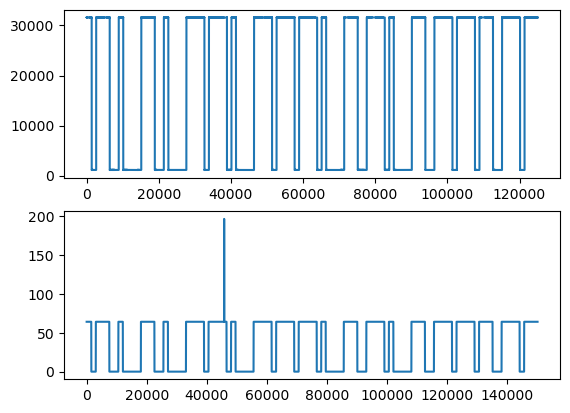

In [52]:
plt.subplot(2,1,1); 
plt.plot(nidq_data[nidq_SampRate*6:nidq_SampRate*11,0])

plt.subplot(2,1,2); 
plt.plot(ap_data[0:0+ap_imSampRate*5,384])

In [51]:
np.shape(nidq_data)[0]/nidq_SampRate

809.35488

In [50]:
np.shape(ap_data)[0]/ap_imSampRate

802.741

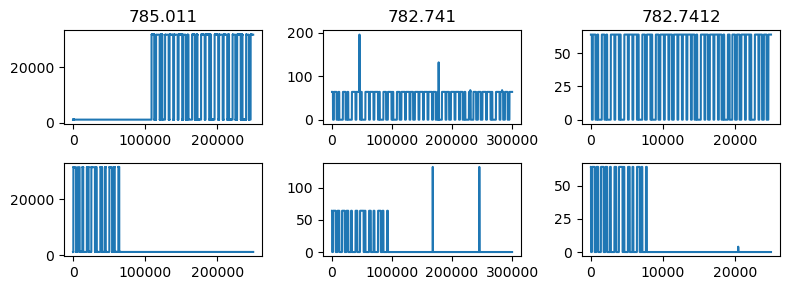

In [18]:
plt.figure(figsize=(8,3))

plt.subplot(2,3,1); 
plt.plot(nidq_data[:nidq_SampRate*10,nidq_syncCH]); 
plt.title(get_sync_dur(nidq_data, nidq_SampRate)); 
plt.subplot(2,3,4); 
plt.plot(nidq_data[-nidq_SampRate*10:,nidq_syncCH]); 

plt.subplot(2,3,2); 
plt.plot(ap_data[:ap_imSampRate*10,384]); 
plt.title(get_sync_dur(ap_data, ap_imSampRate)); 
plt.subplot(2,3,5); 
plt.plot(ap_data[-ap_imSampRate*10:,384]); 

plt.subplot(2,3,3); 
plt.plot(lf_data[:lf_imSampRate*10,384]); 
plt.title(get_sync_dur(lf_data, lf_imSampRate)); 
plt.subplot(2,3,6); 
plt.plot(lf_data[-lf_imSampRate*10:,384]); 

plt.tight_layout(); 

In [45]:
template = np.load('/Volumes/share/Anesthetized_Experiments/rawData/V2/2023_03/P4/01_a220328_RndDot_RFmap_NPX_g4/a220328_RndDot_RFmap_NPX_g4_imec0/templates.npy'); 

In [52]:
chan_best = (template**2).sum(axis=1).argmax(axis=-1)

In [53]:
chan_best

array([  1,   2,   2,   3,   3,   2,   2,   0,   5,   5,   4,   5,   6,
         4,   9,   6,   6,   6,   6,   6,   9,   9,   9,   9,  10,  10,
         8,   8,  11,   9,   9,   8,  10,   9,  17,  14,  14,  14,  12,
        14,  12,  14,  14,  12,  18,  18,  18,  16,  18,  16,  21,  17,
        17,  18,  19,  17,  20,  22,  22,  20,  22,  22,  22,  20,  22,
        20,  20,  20,  21,  25,  21,  21,  27,  22,  26,  26,  26,  26,
        33,  33,  33,  30,  30,  28,  34,  33,  34,  38,  40,  46,  49,
        67,  72,  77,  77,  77,  80,  96,  94, 105, 107, 113, 117, 121,
       125, 129, 129, 133, 134, 129, 137, 133, 135, 133, 135, 133, 137,
       137, 139, 138, 139, 141, 143, 142, 138, 143, 141, 147, 146, 147,
       146, 146, 146, 147, 151, 149, 150, 149, 150, 151, 150, 154, 153,
       157, 154, 157, 154, 158, 156, 157, 157, 158, 157, 158, 162, 163,
       165, 167, 167, 167, 169, 170, 173, 171, 169, 173, 172, 171, 171,
       170, 174, 175, 175, 175, 175, 178, 181, 182, 187, 186, 18